## Product Detection from Packshots

#### To run this notebook firstly download the data from https://www.google.com/url?sa=D&q=https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz&ust=1665751020000000&usg=AOvVaw1IeGyDCCZbccbs_ebaTdeI&hl=en-GB&source=gmail and just execute the cells in the current folder.

In [1]:
# import all the required libraries
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt
import glob
import os

### Detect product from product image

In [2]:
# all images inside product_images folder
files = glob.glob('./product_detection_from_packshots/product_images/*')

In [3]:
def find_largest_contour(image):
    """
    This function finds all the contours in an image and return the largest
    contour area.
    :param image: a binary image
    """
    areaArray = []
    image = image.astype(np.uint8)
    contours, hierarchy = cv2.findContours(
        image,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
    cnt = sorted(contours, key=cv2.contourArea)
    largest_contour = cnt[-1]
    return largest_contour

In [4]:
# loop through each product image and crop the product part
for file in files:
    # product image name
    image_name = file.split('/')[-1]
    # raed image
    image = cv2.imread(file)
    # blur the image to remove the noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # convert the image into gray scale
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    # thersholding the image
    ret, gray = cv2.threshold(gray, 120 , 255, cv2.CHAIN_APPROX_NONE)
    # fimd the largest contour
    contour = find_largest_contour(gray)
    
    # get the segented part based on the largest contour
    image_contour = np.copy(image)
    x, y, w, h = cv2.boundingRect(contour)
    final_crop = image_contour[y:y+h, x:x+w,:]
    
    if not os.path.exists('./product_detection_from_packshots/cropped_product_images/'):
        os.mkdir('./product_detection_from_packshots/cropped_product_images/')
    
    # save the cropped part
    cv2.imwrite(f'./product_detection_from_packshots/cropped_product_images/{image_name}', final_crop)

### Example output

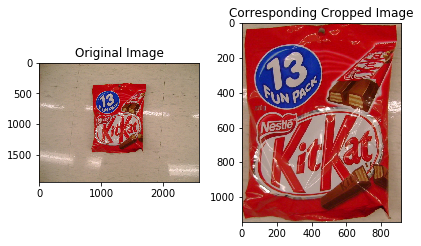

In [5]:
original_image = cv2.imread('./product_detection_from_packshots/product_images/qr281.jpg')
cropped_image = cv2.imread('./product_detection_from_packshots/cropped_product_images/qr281.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cropped_image)
plt.title('Corresponding Cropped Image')
plt.tight_layout()
plt.savefig('sample_crop.png')
plt.show()


## Match the detected product with the shelf image using feature extractor

In [6]:
# minimum match count for a good match
MIN_MATCH_COUNT = 8
# read the product and shelf images folders
product_image_files = glob.glob('./product_detection_from_packshots/cropped_product_images/*.jpg')
shelf_image_files = glob.glob('./product_detection_from_packshots/shelf_images/*.jpg')
print(len(product_image_files), len(shelf_image_files))

300 3153


In [7]:
# loop through each cropped product and shelf image to find a match
for product_image in product_image_files:
    # get the product image id from its name
    product_image_name = product_image.split('/')[-1]
    start_ind = product_image_name.index('r') + 1 
    end_ind = product_image_name.index('.')
    product_id = product_image_name[start_ind:end_ind]
    print(f'Product ID: {product_id}')
    
    img1 = cv2.imread(product_image,0)  # queryImage
    img1 = imutils.resize(img1, width=100)
    
    for shelf_image in shelf_image_files:
        # get the shelf image id from its name
        shelf_image_name = shelf_image.split('/')[-1]
        start_ind = shelf_image_name.index('b') + 1 
        end_ind = shelf_image_name.index('.')
        shelf_id = shelf_image_name[start_ind:end_ind]
    
        img2 = cv2.imread(shelf_image,0) # trainImage
        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        # use flann based matcher to find correspondence between two images
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.8*n.distance:
                good.append(m)
        
        # if the number of good points are above the minimum matching count
        # then a match is found for the product in the shelf image
        if len(good)>MIN_MATCH_COUNT:
            # locate the matching descriptors in the two images and generate a mask
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            h,w = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            
            # find the bouding box of the matched descriptor
            dst = np.squeeze(dst)
            min_x, min_y = np.int32(dst.min(axis=0))
            max_x, max_y = np.int32(dst.max(axis=0))
            
            # write the output into a file
            with open("solutions.txt", "a") as file_object:
                file_object.write(f"{product_id},{shelf_id},{min_x},{min_y},{max_x},{max_y} \n")
            print('Match Found')
        else:
            matchesMask = None

### Example output of matching algorithm

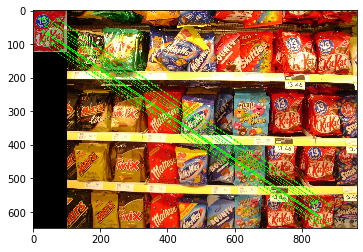

In [8]:
img = plt.imread('sample_output.png')
plt.imshow(img)
plt.show()